In [125]:
# This notebook plots predicted concentration gradients for different wounding conditions 
import sys
import os

sys.path.append(os.path.abspath('..'))

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.special import expi
from scipy.stats import gaussian_kde
import random
import emcee


In [126]:
filesuffix = "_farhalf_1x_Weaverst2_exclSBin1"

# Load inferred parameters for each data type 
Post_attractant_control = emcee.backends.HDFBackend('../data/Attractant_inference/attractant_inference_CTR_revision'+filesuffix+'.h5')
Post_attractant_mcr = emcee.backends.HDFBackend('../data/Attractant_inference/attractant_inference_MCR_revision'+filesuffix+'.h5')

In [127]:
# calculate autocorrelation times (this might take a while... ~1-10min) to estimate burn-in and thinning parameters, then retrieve flattened samples
def calculate_burnin_thin(sampler):
    tau = sampler.get_autocorr_time(tol=0) # use tol=0 here as we don't expect all parameters to converge (some can't be inferred well)
    burnin = int(2 * np.max(tau))
    thin = int(np.min(tau))
    print("burn-in: {0}".format(burnin))
    print("thin: {0}".format(thin))
    return burnin, thin

burnin_ctr, thin_ctr = calculate_burnin_thin(Post_attractant_control)
burnin_mcr, thin_mcr = calculate_burnin_thin(Post_attractant_mcr)

posterior_samples_control = Post_attractant_control.get_chain(discard=burnin_ctr, thin=thin_ctr, flat = True)
posterior_samples_mcr = Post_attractant_mcr.get_chain(discard=burnin_mcr, thin=thin_mcr, flat = True)
# randomly subsample N_sub samples from the posterior  (this speeds up subsequent plotting and mode calculation)
N_sub = 20000
if N_sub < posterior_samples_control.shape[0]:
    posterior_samples_control = posterior_samples_control[np.random.choice(posterior_samples_control.shape[0], N_sub, replace=False)]
if N_sub < posterior_samples_mcr.shape[0]:
    posterior_samples_mcr = posterior_samples_mcr[np.random.choice(posterior_samples_mcr.shape[0], N_sub, replace=False)]

burn-in: 4257
thin: 444
burn-in: 8575
thin: 1267


In [233]:
# Multiple wound function, using the Exponential Integral
def concentration_multiple_sources(x, y, ts, source_locations, q,D, tau):
    concentration_sum = np.zeros_like(x)
    
    for qx, qy in source_locations:
        r = np.sqrt((x - qx)**2 + (y - qy)**2)
        factor = q / (4 * np.pi * D)
        
        if ts < tau:
            concentration_sum += -factor * expi(-r**2 / (4 * D * ts))
        else:
            concentration_sum += factor * (expi(-r**2 / (4 * D * (ts - tau))) - expi(-r**2 / (4 * D * ts)))
    
    return concentration_sum

# Multiple wound function, using the Exponential Integral, taking in radial polar coordinates
def concentration_multiple_source_polar(r, theta, ts, source_locations, q,D, tau):
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    concentration_sum = concentration_multiple_sources(x, y, ts, source_locations, q,D, tau)
    
    return concentration_sum

In [129]:
# Circle function for source points
def circle(r, thetas):
    xs = r * np.cos(thetas)
    ys = r * np.sin(thetas)
    return xs, ys  # Returning xs and ys as a tuple

# Create an array of angles from 0 to π (180 degrees)
theta_half = np.linspace(0, np.pi, 10)
theta_full = np.delete(np.linspace(0, 2*np.pi, 20), -1) # last element is present twice, so remove it to avoid a double strength source


def location_of_sources(halfwound_on, two_wounds=False, wound_radius = 37.0):
    # Calculate the x and y coordinates for points on the half-circle and full circle
    xs_half, ys_half = circle(wound_radius, theta_half) 
    xs_full, ys_full = circle(wound_radius, theta_full)
    if (halfwound_on == True) & (two_wounds == False):
        source_locations = [(xs_half[i],ys_half[i]) for i in range(len(xs_half))]
    elif (two_wounds == True) & (halfwound_on == False): # two wild type wounds
        source_locations = [(xs_full[i],ys_full[i] + 85) for i in range(len(xs_full))]
        source_locations += [(xs_full[i],ys_full[i] - 85) for i in range(len(xs_full))]
    elif (two_wounds == True) & (halfwound_on == True): # one wild type wound and one Mcr kd wound
        source_locations = [(xs_full[i],ys_full[i] + 85) for i in range(len(xs_full))]
    else:
        source_locations = [(xs_full[i],ys_full[i]) for i in range(len(xs_full))]
    return source_locations
    
def strength_of_sources(halfwound_on, flow_rate):
    if halfwound_on == True:
        source_strength = flow_rate / 2 / len(theta_half)
    else:
        source_strength = flow_rate / len(theta_full)
    return source_strength

def kde_mode(values):
    pdf_estimate = gaussian_kde(values)
    return values[np.argmax(pdf_estimate.pdf(values))]

def plot_posterior_kde(samples_ctr, samples_mcr, param_index, xlabelstring, xlim=0, savefilename=None):
    # Create a histogram plot with seaborn
    sns.kdeplot(samples_ctr[:,param_index],label='Control', clip=(0,np.Inf))
    sns.kdeplot(samples_mcr[:,param_index], label='MCR KD', clip=(0,np.Inf))

    # Customize the plot
    plt.xlabel(xlabelstring)
    plt.ylabel('Density')
    if xlim>0:
        plt.xlim([0,xlim])
    plt.legend()
    plt.grid(True)
    if savefilename:
        plt.savefig('Figures/PosteriorParameterPlots/'+savefilename)

    # Show the plot
    plt.show()

In [130]:
# extract mean parameters from Posterior distributions, i.e. Diffusion coefficient, flow rate, tau 
D_control = kde_mode(posterior_samples_control[:,1])
q_control = kde_mode(posterior_samples_control[:,0]) 
tau_control = kde_mode(posterior_samples_control[:,2]) 
print(f'D_ctr = {D_control:.1f}; q_ctr = {q_control:.1f}; tau_ctr = {tau_control:.1f}')

D_mcr = kde_mode(posterior_samples_mcr[:,1])
q_mcr = kde_mode(posterior_samples_mcr[:,0]) 
tau_mcr = kde_mode(posterior_samples_mcr[:,2]) 
print(f'D_mcr = {D_mcr:.1f}; q_mcr = {q_mcr:.1f}; tau_mcr = {tau_mcr:.1f}')

D_ctr = 222.8; q_ctr = 61.6; tau_ctr = 18.0
D_mcr = 20.2; q_mcr = 92.9; tau_mcr = 0.8


In [211]:
# ## use this only to generate diffusion plots as per Weavers, Liepe et al.
filesuffix ="_WeaversLiepePrediction"
D_control = 200
q_control = 1750 # prior mean
tau_control = 18 

## farhalf_1x_Weaverst2_exclSBin1
# D_control = 219-224
# tau_control = 18
# q_control = 62

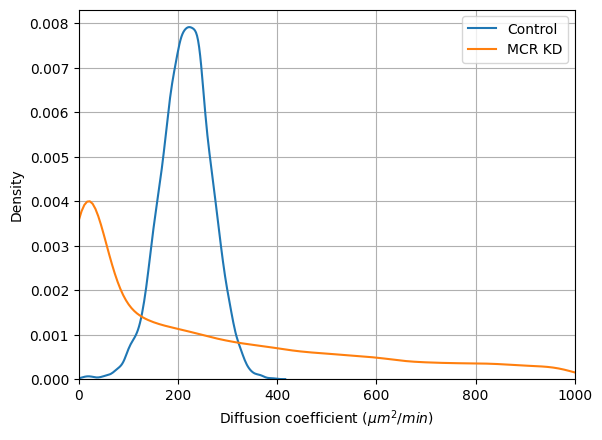

In [131]:
plot_posterior_kde(posterior_samples_control, posterior_samples_mcr, 
                   1, 'Diffusion coefficient ($\mu m^2/min$)', xlim=1000, savefilename='Diffusion_coefficients'+filesuffix+'.pdf')

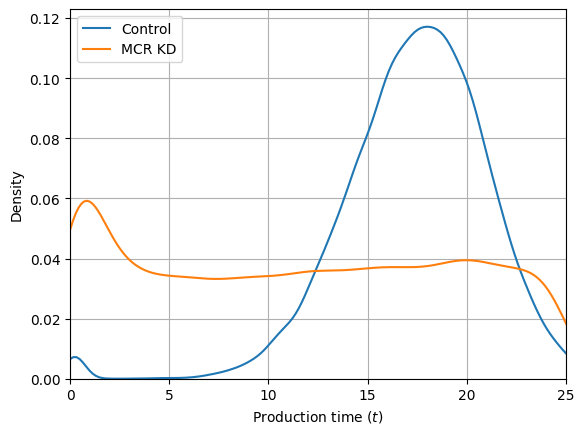

In [132]:
plot_posterior_kde(posterior_samples_control, posterior_samples_mcr, 
                   2, 'Production time ($t$)', xlim=25,
                   savefilename='Production_time'+filesuffix+'.pdf')

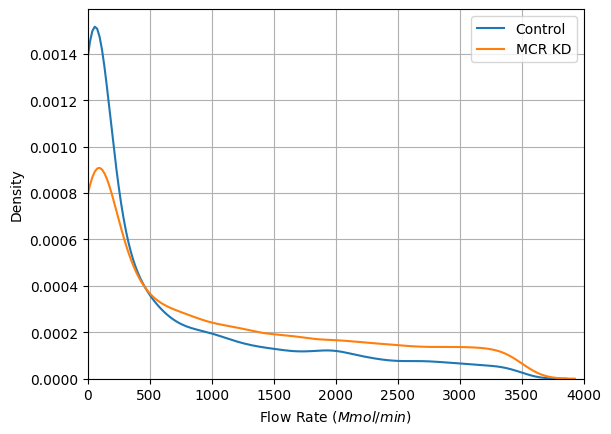

In [133]:
plot_posterior_kde(posterior_samples_control, posterior_samples_mcr, 
                   0, 'Flow Rate ($Mmol / min$)', xlim=4000,
                   savefilename='Flow_rate'+filesuffix+'.pdf')

In [410]:
# set some parameters for plotting
L = 150 # sets the range of plot from -L to L
# Define the grid 
nPoints = 600
x = np.linspace(-L, L, nPoints)
y = np.linspace(-L, L, nPoints)
r = np.linspace(0,L,nPoints)
theta = np.linspace(-np.pi,np.pi,nPoints)
distance = np.linspace(-L,L,nPoints) # Distance in microns for plotting
X, Y = np.meshgrid(x, y)
R, Theta = np.meshgrid(r, theta)

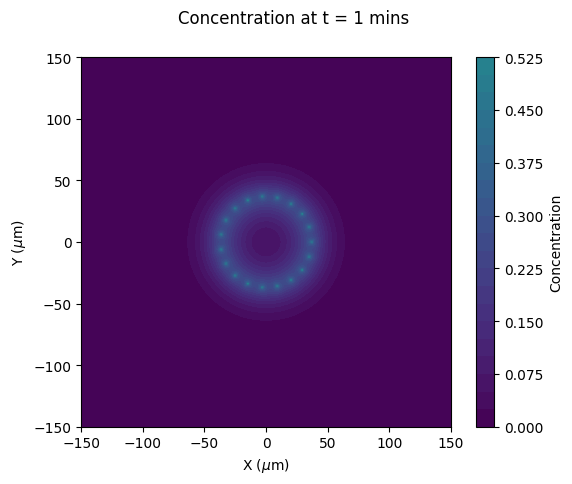

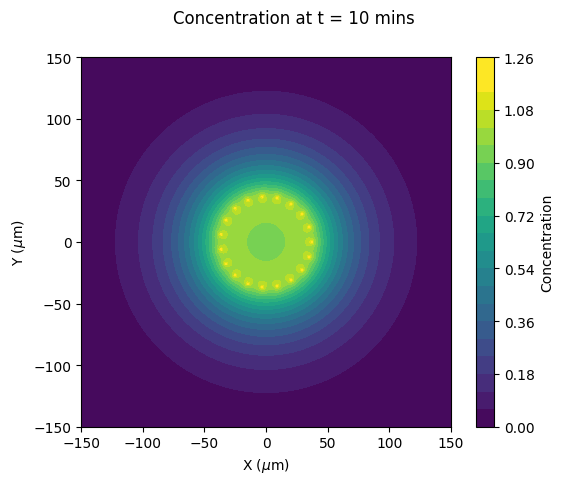

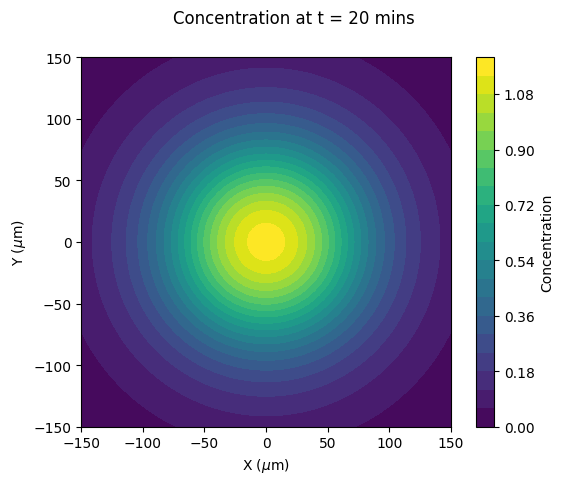

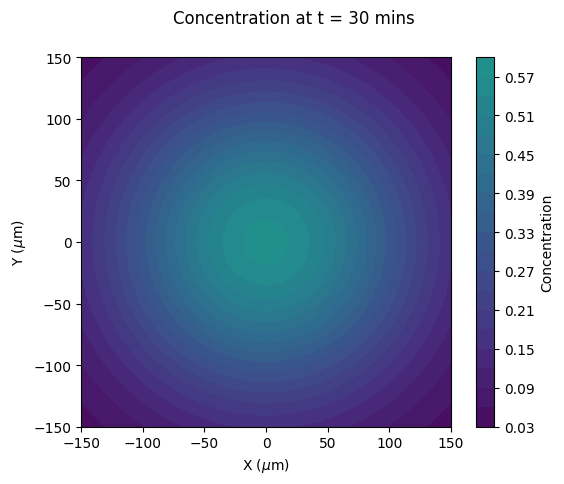

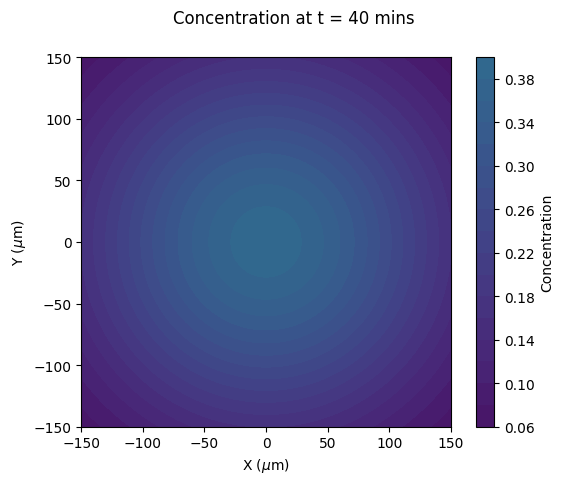

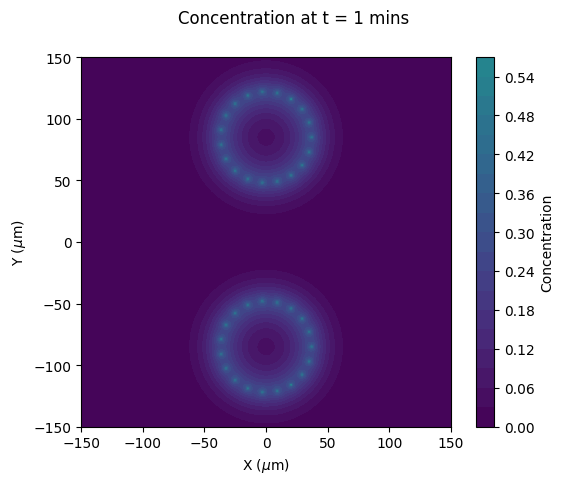

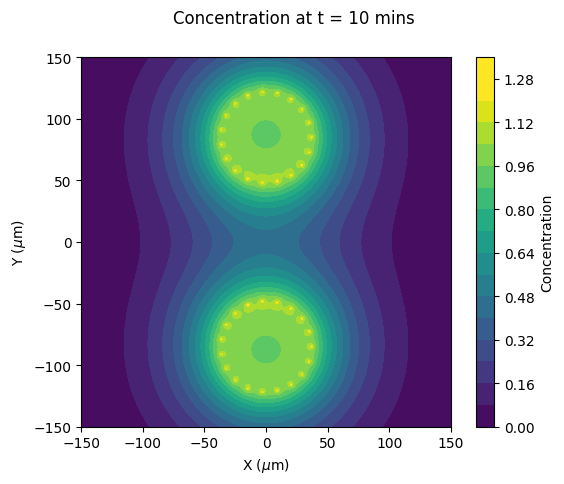

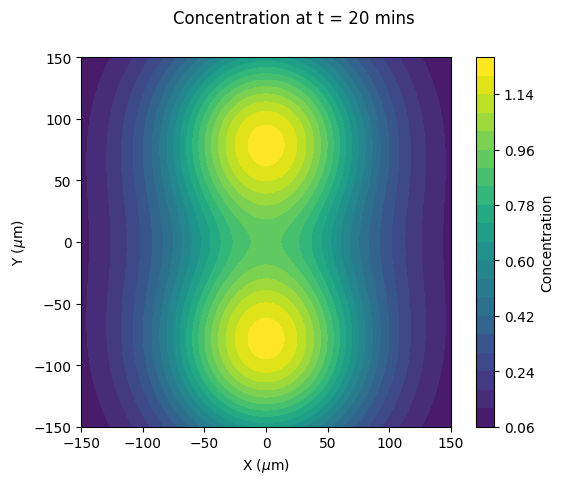

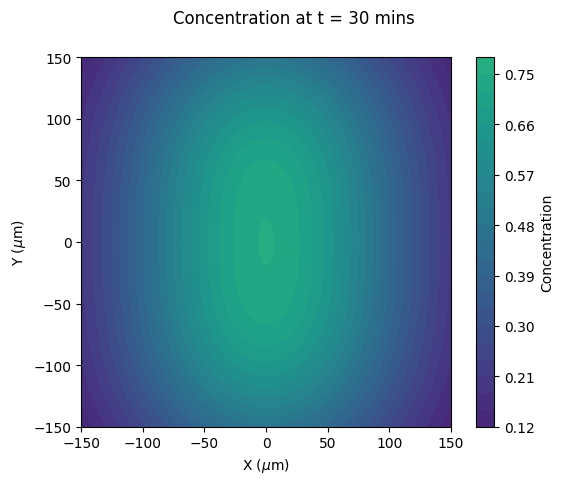

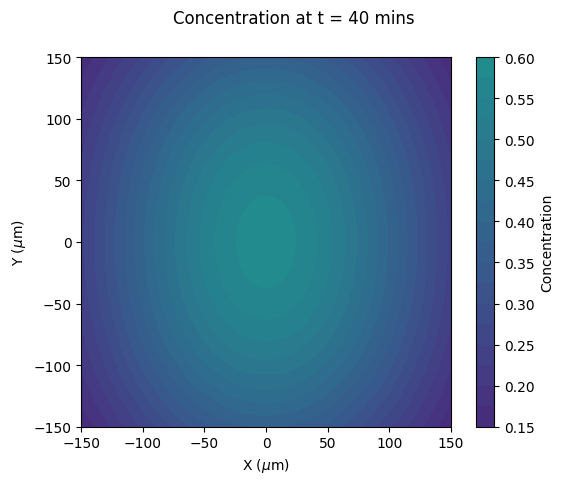

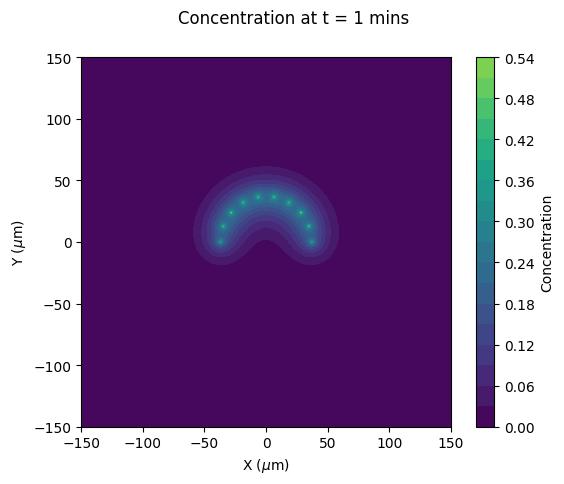

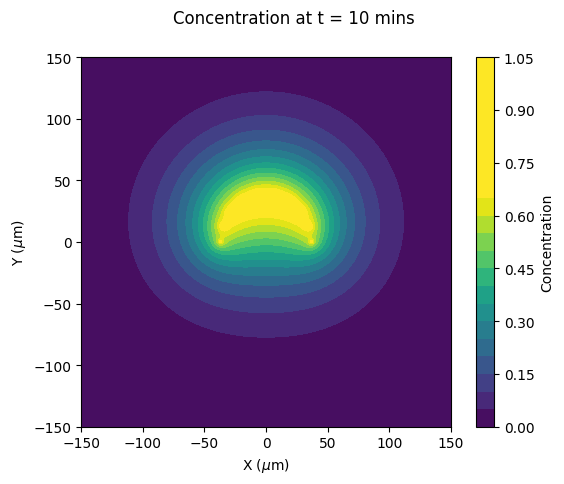

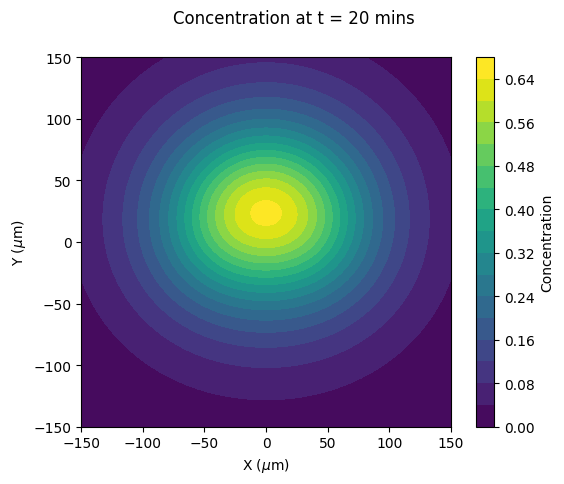

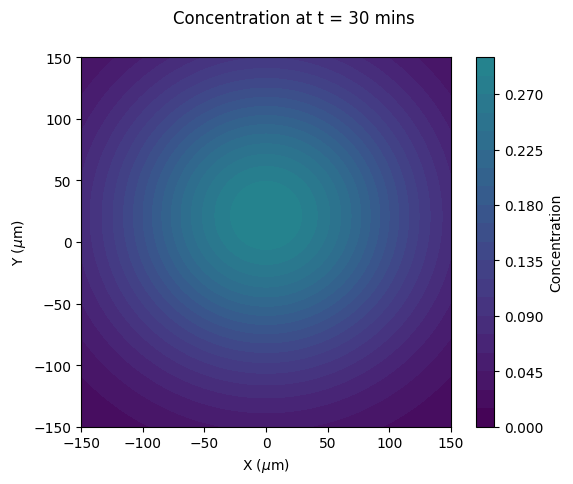

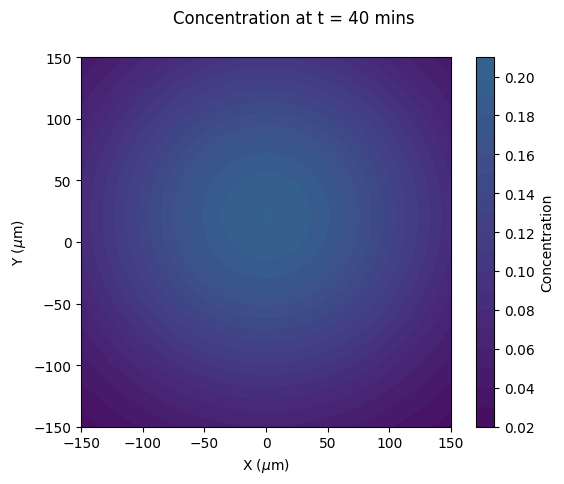

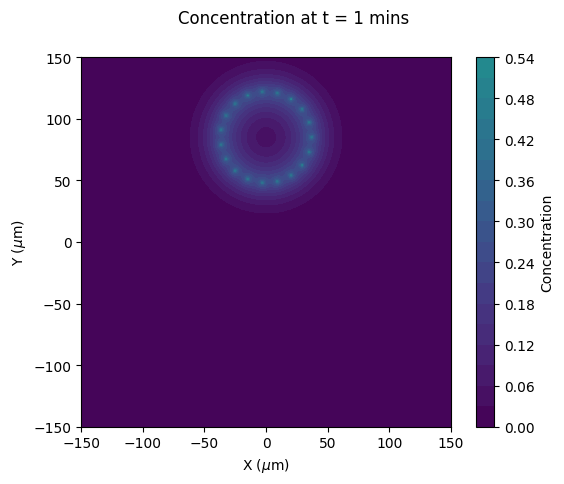

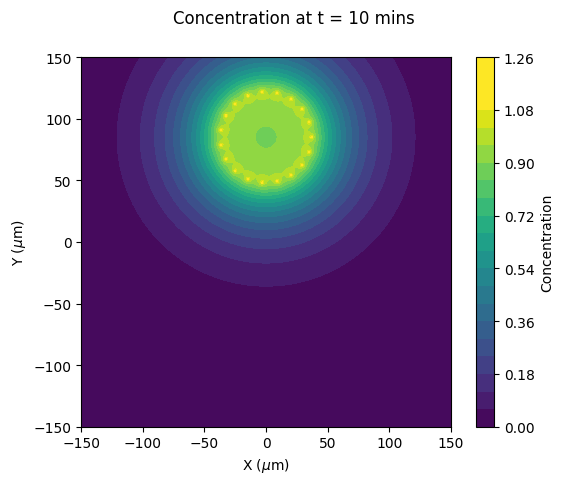

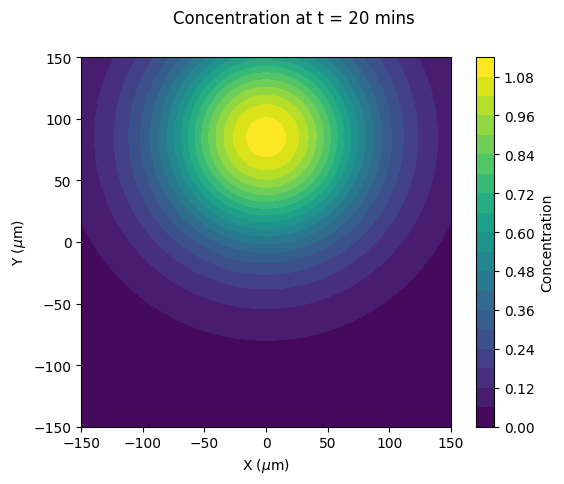

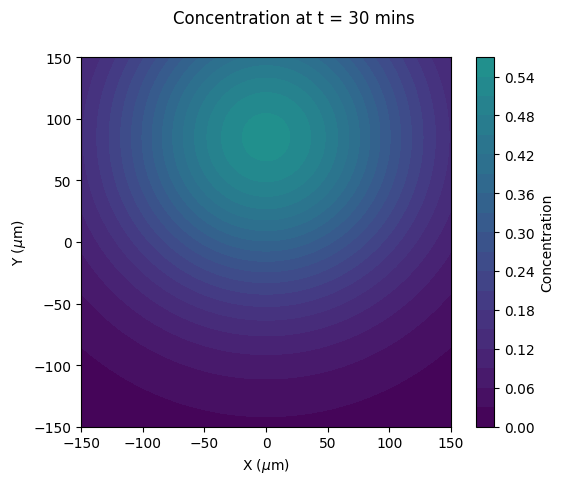

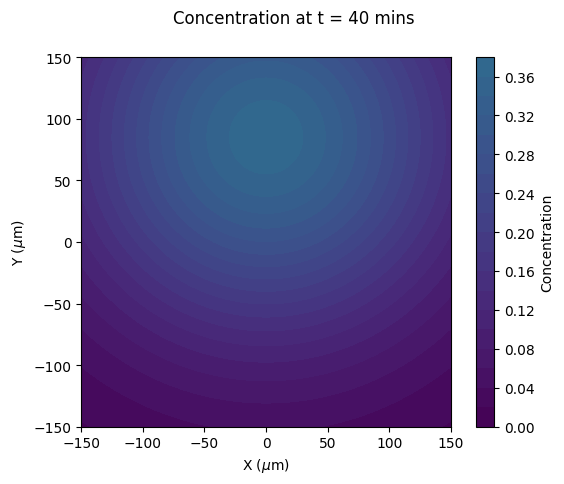

In [411]:
# Produce heatmap of chemoattractant concentration 
# Half wound on or off, if off two wounds are plotted instead
two_wounds = True
for halfwound_on in [False, True]:
    for two_wounds in [False, True]:
        # Define the positions of the point sources
        source_locations = location_of_sources(halfwound_on, two_wounds)
        source_strength = strength_of_sources(halfwound_on, q_control)

        max_concentration = concentration_multiple_sources(X, Y, 20, source_locations, source_strength, D_control, tau_control)
        max_concentration = max_concentration.max()

        for ts in [1, 10, 20, 30, 40]:
            # Set the values of ts, D, and tau
            # ts # current time - min

            # Calculate the concentration at each point in the grid
            concentration = concentration_multiple_sources(X, Y, ts, source_locations, source_strength, D_control, tau_control)

            # plotting 
            fig, ax = plt.subplots(1)
            ax.set_aspect('equal')

            im = ax.contourf(X, Y, concentration, levels=20, vmin=0, vmax=max_concentration)

            ax.set_xlabel('X ($\mu$m)')
            ax.set_ylabel('Y ($\mu$m)')
            cbar = fig.colorbar(im)
            cbar.set_label('Concentration')

            fig.suptitle(f'Concentration at t = {int(ts)} mins')
            if (halfwound_on == True) & (two_wounds == False):
                plt.savefig(f"Figures/DiffusionPlots/Half wound concentration at t = {ts}"+filesuffix+".pdf")
            elif (two_wounds == True) & (halfwound_on == False):
                plt.savefig(f"Figures/DiffusionPlots/Two wound concentration at t = {ts}"+filesuffix+".pdf")
            elif (two_wounds == True) & (halfwound_on == True):
                plt.savefig(f"Figures/DiffusionPlots/Two wound one KD concentration at t = {ts}"+filesuffix+".pdf")
            else:
                plt.savefig(f"Figures/DiffusionPlots/Single wound concentration at t = {ts}"+filesuffix+".pdf")
            plt.show()


In [108]:
max_concentration

0.03891010752605668

/var/folders/92/tvn4jggs62qb78rd70twcy7w0000gn/T/ipykernel_37673/83584084.py:32: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


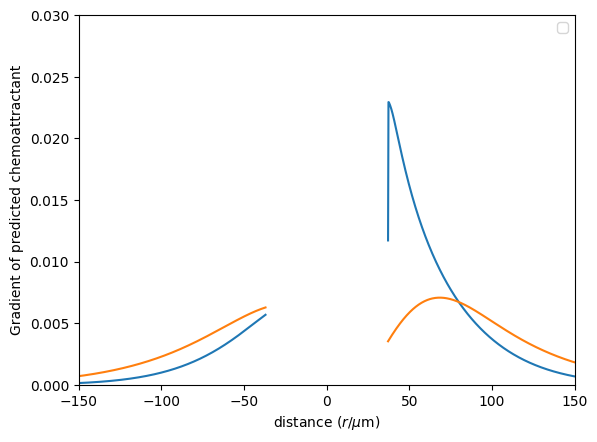

In [370]:
# next will plot line plots of the predicted bias for half wound data
# this needs to be averaged over multiple time-windows to compare with data
# Define the positions of the point sources
show_range=False
this_wound_radius = 37.0
source_locations = location_of_sources(halfwound_on=True, two_wounds=False, wound_radius = this_wound_radius)
source_strength = strength_of_sources(halfwound_on=True, flow_rate=q_control)

wound_edge_indices = [next(i for i, x in enumerate(distance) if x>-this_wound_radius), next(i for i, x in enumerate(distance) if x>this_wound_radius)]
outside_wound_indices_r = r>(this_wound_radius)

color_list = ['tab:blue', 'tab:orange']
for i, ts in enumerate([10,20]):
    # if wanting to plot concentration along a line x=0, use the following code
    # concentration_half = concentration_multiple_sources(X, Y, ts, source_locations, source_strength,D_control, tau_control)  
    # absolute_concentration_grad = np.absolute(np.gradient(concentration_half[:, int(nPoints/2)],y))
    # plt.plot(distance[:wound_edge_indices[0]],absolute_concentration_grad[:wound_edge_indices[0]],color_list[i])
    # plt.plot(distance[wound_edge_indices[1]:],absolute_concentration_grad[wound_edge_indices[1]:],color_list[i], label=str(ts)+' min')

    # the following plots the gradient vs r averaged over the range pi/4 to 3pi/4 and -3pi/4 to -pi/4
    concentration_half_polar = concentration_multiple_source_polar(R, Theta, ts, source_locations, source_strength,D_control, tau_control)
    absolute_concentration_grad_polar_CTRhalf = np.absolute(np.mean(np.gradient(concentration_half_polar[(theta<np.pi*3/4)&(theta>np.pi/4),:],r,axis=1),axis=0))
    absolute_concentration_grad_polar_KDhalf = np.absolute(np.mean(np.gradient(concentration_half_polar[(theta>-np.pi*3/4)&(theta<-np.pi/4),:],r,axis=1),axis=0))
    plt.plot(r[outside_wound_indices_r],absolute_concentration_grad_polar_CTRhalf[outside_wound_indices_r],color_list[i])
    plt.plot(-r[outside_wound_indices_r],absolute_concentration_grad_polar_KDhalf[outside_wound_indices_r],color_list[i])
    if show_range:
        absolute_concentration_grad_polar_CTRhalf_range = np.absolute(np.gradient(concentration_half_polar[(theta<np.pi*3/4)&(theta>np.pi/4),:],r,axis=1))
        absolute_concentration_grad_polar_KDhalf_range = np.absolute(np.gradient(concentration_half_polar[(theta>-np.pi*3/4)&(theta<-np.pi/4),:],r,axis=1))
        plt.plot(r[outside_wound_indices_r],absolute_concentration_grad_polar_CTRhalf_range[:,outside_wound_indices_r].T,color_list[i], alpha=0.025)
        plt.plot(-r[outside_wound_indices_r],absolute_concentration_grad_polar_KDhalf_range[:,outside_wound_indices_r].T,color_list[i], alpha=0.025)

plt.legend()
plt.xlim(-150,150)
plt.ylim(0,0.03)
plt.xlabel("distance ($r/\mu$m)")
plt.ylabel("Gradient of predicted chemoattractant")
if show_range:
    plt.savefig(f"Figures/PredictedBiasPlots/Half wound predicted bias"+filesuffix+".pdf")
else:
    plt.savefig(f"Figures/PredictedBiasPlots/Half wound predicted bias_withoutrange"+filesuffix+".pdf")
plt.show()

In [110]:
# # plot muliple lines for different samples from the posterior distribution
# # CHANGE THIS TO SAMPLE JOINTLY RATHER THAN MARGINALS
# # generate some random samples to plot
# num_samples_total = len(posterior_samples_control)
# num_samples_to_plot = 100
# # now choose 100 random integers between 0 and num_samples_total
# samples_to_plot = np.random.randint(0, num_samples_total, num_samples_to_plot)

# multi_gradients = []
# for i in range(num_samples_to_plot):
#     this_sample = samples_to_plot[i]
#     concentration_half = concentration_multiple_sources(X, Y, 5, source_locations, strength_of_sources(halfwound_on=True, flow_rate=posterior_samples_control[this_sample,0]),
#                                                         posterior_samples_control[this_sample,1], posterior_samples_control[this_sample,2])
#     multi_gradients.append(np.absolute(np.gradient(concentration_half[:,int(nPoints/2)])))

In [111]:
# for i in range(len(multi_gradients)):
#     plt.plot(distance,multi_gradients[i], 'r', alpha = 0.1)
# plt.show()

In [413]:
# Two-wound plots
this_wound_radius = 8.0
source_locations2 = location_of_sources(halfwound_on=False, two_wounds=True, wound_radius = this_wound_radius)
# shift the wound locations for the following plots so that one wound is at the origin
source_locations2_shifted = [(x,y-85) for x,y in source_locations2]

source_strength2 = strength_of_sources(halfwound_on=False, flow_rate=q_control)

# concentration_1 = concentration_multiple_sources(X, Y, 1, source_locations2, source_strength2, D_control, tau_control)
concentration_10 = concentration_multiple_sources(X, Y, 10, source_locations2_shifted, source_strength2, D_control, tau_control)
concentration_20 = concentration_multiple_sources(X, Y, 20, source_locations2_shifted, source_strength2, D_control, tau_control)

In [414]:
# Two-wound plots in radial coords
# concentration_1_polar = concentration_multiple_source_polar(R, Theta, 1, source_locations2, source_strength2, D_control, tau_control)
concentration_10_polar = concentration_multiple_source_polar(R, Theta, 10, source_locations2_shifted, source_strength2, D_control, tau_control)
concentration_20_polar = concentration_multiple_source_polar(R, Theta, 20, source_locations2_shifted, source_strength2, D_control, tau_control)

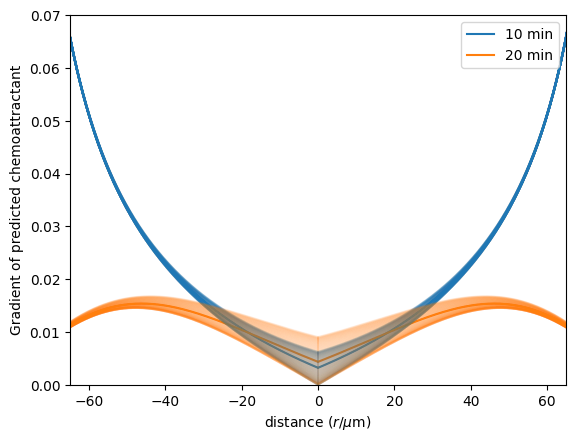

In [457]:
show_average_prediction = True # whether to show a linen prediction for the middle y-coordinate, or an average across the width of the wound
show_range = True # whether to show the range of gradients around the mean
plot_polar = True
this_alpha = 0.05
plot_indices = r<85
if plot_polar:
    # the following plots the gradient vs r averaged over the range pi/4 to 3pi/4 and -3pi/4 to -pi/4
    # mean gradient over the range pi/4 to 3pi/4 and -3pi/4 to -pi/4
    # bottom wound
    plt.plot(r[plot_indices]-85,np.absolute(np.mean(np.gradient(concentration_10_polar[(theta>-np.pi*3/4)&(theta<-np.pi/4),:],r,axis=1),axis=0))[plot_indices], label = "10 min", color="tab:blue")
    plt.plot(r[plot_indices]-85,np.absolute(np.mean(np.gradient(concentration_20_polar[(theta>-np.pi*3/4)&(theta<-np.pi/4),:],r,axis=1),axis=0))[plot_indices], label = "20 min", color="tab:orange")
    # # top wound
    plt.plot(85-r[plot_indices],np.absolute(np.mean(np.gradient(concentration_10_polar[(theta>-np.pi*3/4)&(theta<-np.pi/4),:],r,axis=1),axis=0))[plot_indices], color="tab:blue")
    plt.plot(85-r[plot_indices],np.absolute(np.mean(np.gradient(concentration_20_polar[(theta>-np.pi*3/4)&(theta<-np.pi/4),:],r,axis=1),axis=0))[plot_indices], color="tab:orange")
    if show_range:
        # range of gradients over the range pi/4 to 3pi/4 and -3pi/4 to -pi/4
        # bottom wound
        plt.plot(r[plot_indices]-85,np.absolute(np.gradient(concentration_10_polar[(theta>-np.pi*3/4)&(theta<-np.pi/4),:],r,axis=1)).T[plot_indices,:], color="tab:blue", alpha=this_alpha)
        plt.plot(r[plot_indices]-85,np.absolute(np.gradient(concentration_20_polar[(theta>-np.pi*3/4)&(theta<-np.pi/4),:],r,axis=1)).T[plot_indices,:], color="tab:orange", alpha=this_alpha)
        # # top wound
        plt.plot(85-r[plot_indices],np.absolute(np.gradient(concentration_10_polar[(theta>-np.pi*3/4)&(theta<-np.pi/4),:],r,axis=1)).T[plot_indices,:], color="tab:blue", alpha=this_alpha)
        plt.plot(85-r[plot_indices],np.absolute(np.gradient(concentration_20_polar[(theta>-np.pi*3/4)&(theta<-np.pi/4),:],r,axis=1)).T[plot_indices,:], color="tab:orange", alpha=this_alpha)
else:
    if show_average_prediction:
        # mean gradient across the width of the wound
        plt.plot(distance,np.absolute(np.mean(np.gradient(concentration_10[:,int(nPoints*(1/2 - 35/300)):int(nPoints*(1/2 + 35/300))],y,axis=0),axis=-1)), label = "10 min")
        plt.plot(distance,np.absolute(np.mean(np.gradient(concentration_20[:,int(nPoints*(1/2 - 35/300)):int(nPoints*(1/2 + 35/300))],y,axis=0),axis=-1)), label = "20 min")
        # range of gradients across the width of the wound
        plt.plot(distance,np.absolute(np.gradient(concentration_10[:,int(nPoints*(1/2 - 35/300)):int(nPoints*(1/2 + 35/300))],y,axis=0)), alpha=0.1, color="tab:blue")
        plt.plot(distance,np.absolute(np.gradient(concentration_20[:,int(nPoints*(1/2 - 35/300)):int(nPoints*(1/2 + 35/300))],y,axis=0)), alpha=0.1, color="tab:orange")
    else:
        plt.plot(distance,np.absolute(np.gradient(concentration_10[:,int(nPoints/2)],y)), label = "10 min")
        plt.plot(distance,np.absolute(np.gradient(concentration_20[:,int(nPoints/2)],y)), label = "20 min")

# plt.ylim(0,0.0026)
plt.ylim(0,0.07)
plt.xlim(-65,65)
# plt.xticks(np.linspace(-75,75,7))
plt.legend()
plt.xlabel("distance ($r/\mu$m)")
plt.ylabel("Gradient of predicted chemoattractant")
if show_average_prediction:
    if show_range:
        plt.savefig("Figures/PredictedBiasPlots/Two wound predicted bias average"+filesuffix+".pdf")
    else:
        plt.savefig("Figures/PredictedBiasPlots/Two wound predicted bias average_withoutrange"+filesuffix+".pdf")
else:
    plt.savefig("Figures/PredictedBiasPlots/Two wound predicted bias"+filesuffix+".pdf")
plt.show()

In [439]:
# two wounds with one KD
this_wound_radius = 8.0
source_locations2KD = location_of_sources(halfwound_on=True, two_wounds=True, wound_radius = this_wound_radius)
# shift the wound locations for the following plots so that one wound is at the origin
source_locations2KD_shifted = [(x,y-85) for x,y in source_locations2KD]
source_strength2KD = strength_of_sources(halfwound_on=False, flow_rate=q_control)

concentration_10KD = concentration_multiple_sources(X, Y, 10, source_locations2KD_shifted, source_strength2KD, D_control, tau_control)
concentration_20KD = concentration_multiple_sources(X, Y, 20, source_locations2KD_shifted, source_strength2KD, D_control, tau_control)

In [440]:
# two-wound one KD plots in radial coords
concentration_10KD_polar = concentration_multiple_source_polar(R, Theta, 10, source_locations2KD_shifted, source_strength2KD, D_control, tau_control)
concentration_20KD_polar = concentration_multiple_source_polar(R, Theta, 20, source_locations2KD_shifted, source_strength2KD, D_control, tau_control)

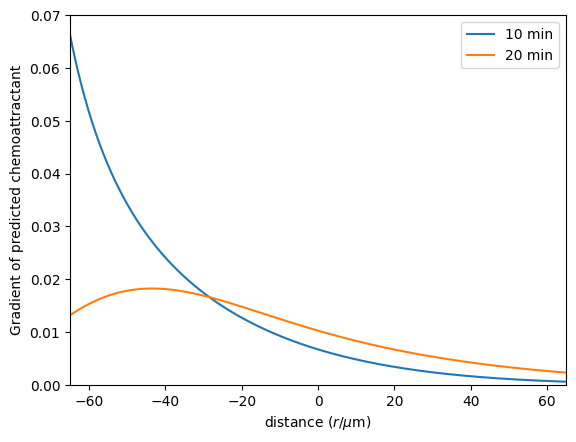

In [453]:
show_average_prediction = True # whether to show a linen prediction for the middle y-coordinate, or an average across the width of the wound
show_range = False # whether to show the range of gradients around the mean
plot_polar = True
this_alpha = 0.05
if plot_polar:
    # the following plots the gradient vs r averaged over the range pi/4 to 3pi/4 and -3pi/4 to -pi/4
    # mean gradient over the range pi/4 to 3pi/4 and -3pi/4 to -pi/4
    # CTR wound - flipped to the other side to match experimental comparison
    plt.plot(r-85,np.absolute(np.mean(np.gradient(concentration_10KD_polar[(theta<np.pi*3/4)&(theta>np.pi/4),:],r,axis=1),axis=0)), label = "10 min", color="tab:blue")
    plt.plot(r-85,np.absolute(np.mean(np.gradient(concentration_20KD_polar[(theta<np.pi*3/4)&(theta>np.pi/4),:],r,axis=1),axis=0)), label = "20 min", color="tab:orange")
    if show_range:
        # range of gradients over the range pi/4 to 3pi/4 and -3pi/4 to -pi/4
        # CTR wound
        plt.plot(r-85,np.absolute(np.gradient(concentration_10KD_polar[(theta<np.pi*3/4)&(theta>np.pi/4),:],r,axis=1)).T, color="tab:blue", alpha=this_alpha)
        plt.plot(r-85,np.absolute(np.gradient(concentration_20KD_polar[(theta<np.pi*3/4)&(theta>np.pi/4),:],r,axis=1)).T, color="tab:orange", alpha=this_alpha)
else:
    if show_average_prediction:
        # mean gradient across the width of the wound
        plt.plot(distance,np.absolute(np.mean(np.gradient(concentration_10KD[:,int(nPoints*(1/2 - 35/300)):int(nPoints*(1/2 + 35/300))],y,axis=0),axis=-1)), label = "10 min")
        plt.plot(distance,np.absolute(np.mean(np.gradient(concentration_20KD[:,int(nPoints*(1/2 - 35/300)):int(nPoints*(1/2 + 35/300))],y,axis=0),axis=-1)), label = "20 min")
        # range of gradients across the width of the wound
        plt.plot(distance,np.absolute(np.gradient(concentration_10KD[:,int(nPoints*(1/2 - 35/300)):int(nPoints*(1/2 + 35/300))],y,axis=0)), alpha=0.1, color="tab:blue")
        plt.plot(distance,np.absolute(np.gradient(concentration_20KD[:,int(nPoints*(1/2 - 35/300)):int(nPoints*(1/2 + 35/300))],y,axis=0)), alpha=0.1, color="tab:orange")
    else:
        plt.plot(distance,np.absolute(np.gradient(concentration_10KD[:,int(nPoints/2)])), label = "10 min")
        plt.plot(distance,np.absolute(np.gradient(concentration_20KD[:,int(nPoints/2)])), label = "20 min")

# plt.ylim(0,0.0026)
plt.ylim(0,0.07)
plt.xlim(-65,65)
# plt.xticks(np.linspace(-75,75,7))
plt.legend()
plt.xlabel("distance ($r/\mu$m)")
plt.ylabel("Gradient of predicted chemoattractant")
if show_average_prediction:
    if show_range:
        plt.savefig("Figures/PredictedBiasPlots/Two wound one KD predicted bias average"+filesuffix+".pdf")
    else:
        plt.savefig("Figures/PredictedBiasPlots/Two wound one KD predicted bias average_withoutrange"+filesuffix+".pdf")
else:
    plt.savefig("Figures/PredictedBiasPlots/Two wound KD predicted bias"+filesuffix+".pdf")
plt.show()